In [4]:
import numpy as np
from collections import Counter

# Load the combined_labels.npy file
combined_labels = np.load('combined_labels.npy', allow_pickle=True)

combined_data = np.load('combined_data.npy', allow_pickle=True)

# If the labels are in a structured format (e.g., dictionary), you might need to adjust
# For simplicity, assuming it's a 1D array of labels
labels = combined_labels

# Count the frequency of each label
label_counts = Counter(labels)

# Print the unique labels and their frequencies
print("Label Titles and Frequencies:")
for label, count in label_counts.most_common():
    print(f"{label}: {count}")

# Additional statistics
print("\nAdditional Statistics:")
print(f"Total number of labels: {len(labels)}")
print(f"Number of unique labels: {len(label_counts)}")

Label Titles and Frequencies:
8: 5391
2: 821
3: 334
4: 298
5: 131
7: 87
6: 67
14: 12

Additional Statistics:
Total number of labels: 7141
Number of unique labels: 8


In [5]:

print("[INFO] Combined data shape:", combined_data.shape)
print("[INFO] Combined label shape:", combined_labels.shape)
print("[INFO] Example entry (first window, first time step):", combined_data[0][0])


[INFO] Combined data shape: (7141, 41, 22)
[INFO] Combined label shape: (7141,)
[INFO] Example entry (first window, first time step): [-5.87737800e+00  1.32205100e+00  8.61249100e+00 -1.06526400e-02
  1.17179100e-02 -2.13052900e-02  2.26842736e-04  5.35707827e-05
 -6.92888209e-04  3.84678680e+02  6.73422241e+01 -7.44161415e+00
  3.52972565e+01  2.48653755e+01  1.00527420e+01  1.69245567e+01
  1.17348299e+01  2.14188719e+00  3.20608592e+00 -3.73420286e+00
  4.27415133e+00  8.14015388e+00]


Epoch 1: Train Acc = 0.8321, Test Acc = 0.9029
Epoch 2: Train Acc = 0.9443, Test Acc = 0.9229
Epoch 3: Train Acc = 0.9486, Test Acc = 0.9400
Epoch 4: Train Acc = 0.9650, Test Acc = 0.9571
Epoch 5: Train Acc = 0.9579, Test Acc = 0.9286
Epoch 6: Train Acc = 0.9693, Test Acc = 0.9343
Epoch 7: Train Acc = 0.9714, Test Acc = 0.9314
Epoch 8: Train Acc = 0.9729, Test Acc = 0.9371
Epoch 9: Train Acc = 0.9750, Test Acc = 0.9371
Epoch 10: Train Acc = 0.9807, Test Acc = 0.9343
Epoch 11: Train Acc = 0.9829, Test Acc = 0.9543
Epoch 12: Train Acc = 0.9843, Test Acc = 0.9629
Epoch 13: Train Acc = 0.9879, Test Acc = 0.9429
Epoch 14: Train Acc = 0.9879, Test Acc = 0.9514
Epoch 15: Train Acc = 0.9850, Test Acc = 0.9286
Epoch 16: Train Acc = 0.9886, Test Acc = 0.9371
Epoch 17: Train Acc = 0.9886, Test Acc = 0.9600
Epoch 18: Train Acc = 0.9907, Test Acc = 0.9600
Epoch 19: Train Acc = 0.9914, Test Acc = 0.9743
Epoch 20: Train Acc = 0.9914, Test Acc = 0.9571
Epoch 21: Train Acc = 0.9929, Test Acc = 0.9657
E

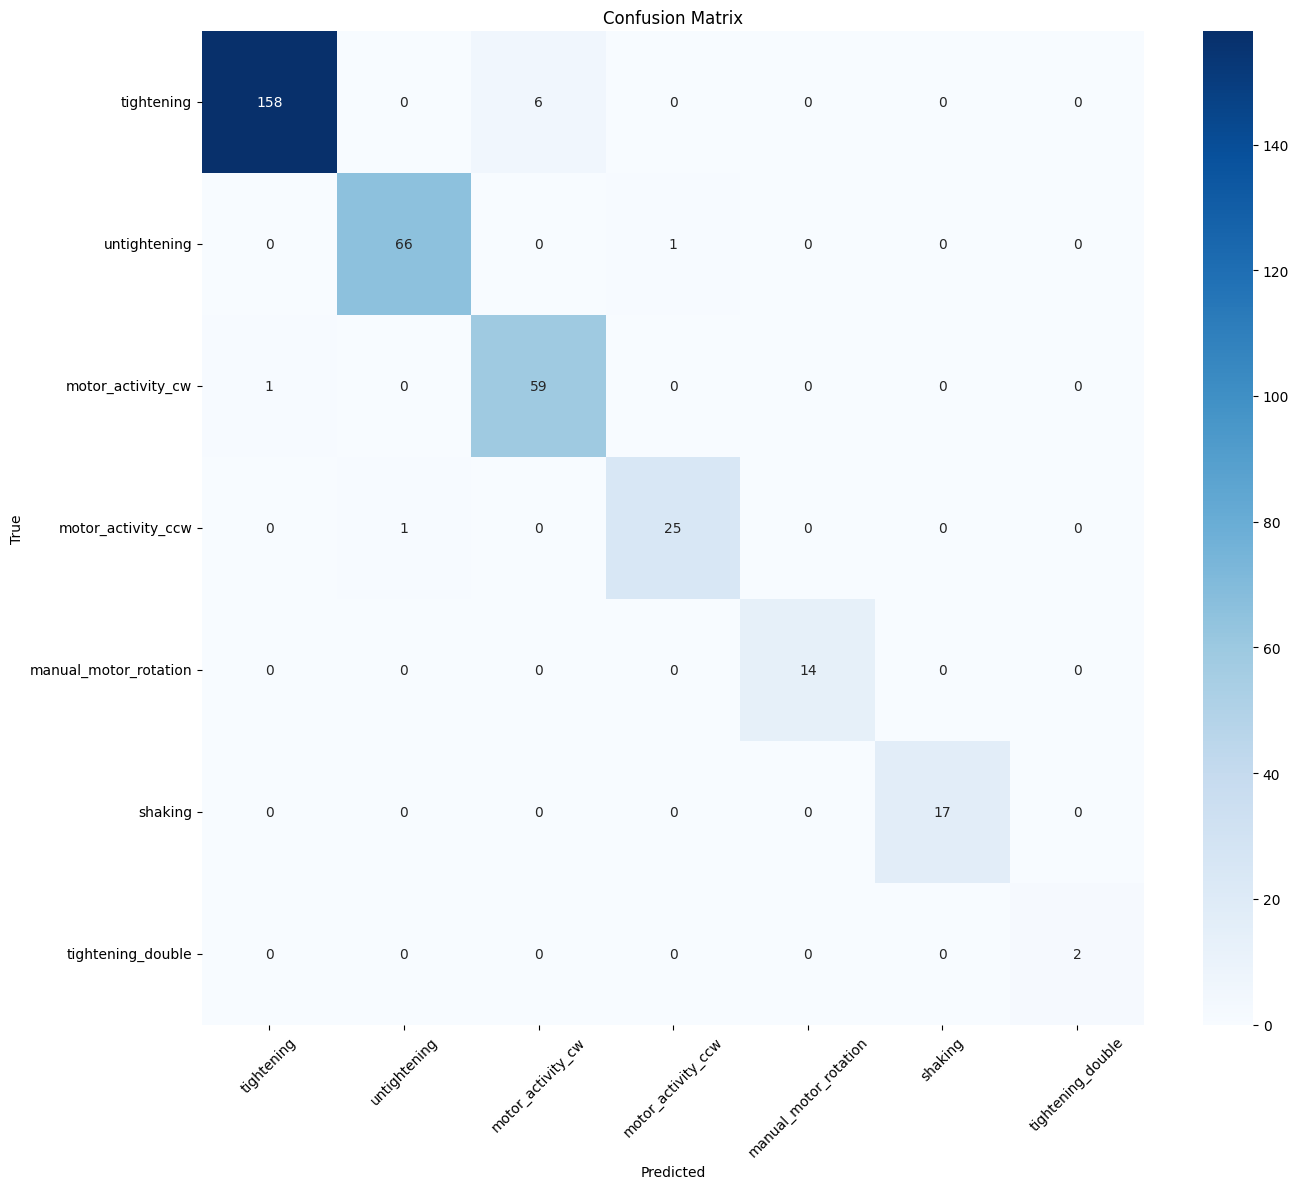


Classification Report:
                       precision    recall  f1-score   support

           tightening       0.99      0.96      0.98       164
         untightening       0.99      0.99      0.99        67
    motor_activity_cw       0.91      0.98      0.94        60
   motor_activity_ccw       0.96      0.96      0.96        26
manual_motor_rotation       1.00      1.00      1.00        14
              shaking       1.00      1.00      1.00        17
    tightening_double       1.00      1.00      1.00         2

             accuracy                           0.97       350
            macro avg       0.98      0.98      0.98       350
         weighted avg       0.98      0.97      0.97       350



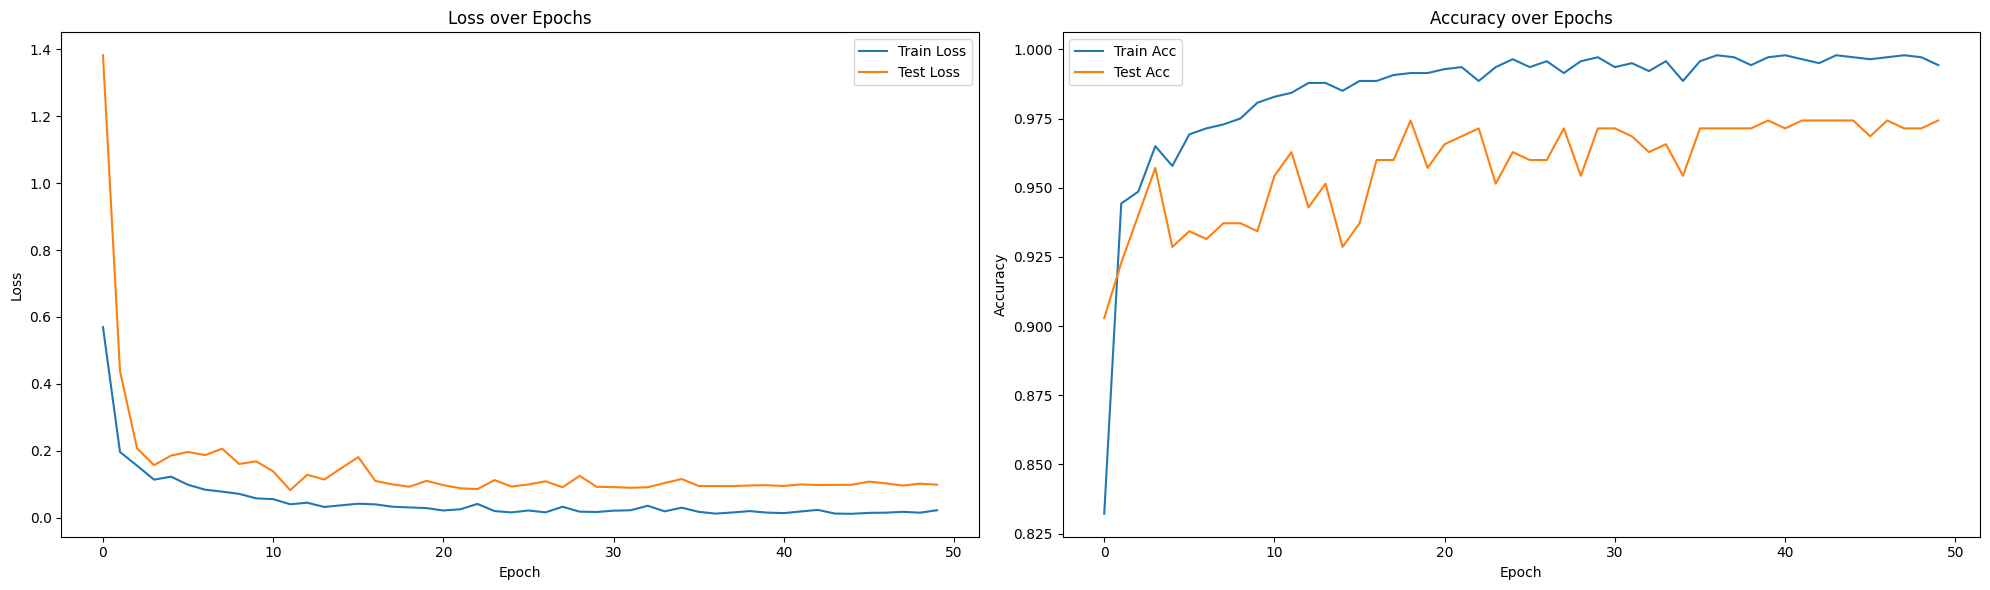

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- Dummy placeholders (replace with actual data loading) ---
# combined_data = np.load(...)  # shape: (samples, timesteps, features)
# combined_labels = np.load(...)  # shape: (samples,)

# Label mapping
label_info = {
    2: 'tightening',
    3: 'untightening',
    4: 'motor_activity_cw',
    5: 'motor_activity_ccw',
    6: 'manual_motor_rotation',
    7: 'shaking',
    14: 'tightening_double'
}

valid_labels = list(label_info.keys())
valid_indices = np.isin(combined_labels, valid_labels)
X = combined_data[valid_indices]
y = combined_labels[valid_indices]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, stratify=y_encoded, random_state=42
)

scaler = StandardScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[2])
X_test_reshaped = X_test.reshape(-1, X_test.shape[2])
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)
X_train = torch.FloatTensor(X_train_scaled.reshape(X_train.shape))
X_test = torch.FloatTensor(X_test_scaled.reshape(X_test.shape))

# --- Weighted Sampling for class imbalance ---
class_sample_counts = np.array([(y_train == t).sum() for t in torch.unique(y_train)])
weights = 1. / class_sample_counts
samples_weight = np.array([weights[t] for t in y_train.numpy()])
samples_weight = torch.from_numpy(samples_weight).float()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# --- BiLSTM Model with Attention ---
class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.attn = nn.Sequential(
            nn.Linear(2 * hidden_size, 2 * hidden_size),
            nn.Tanh(),
            nn.Linear(2 * hidden_size, 1),
            nn.Softmax(dim=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        out, _ = self.bilstm(x)
        out = self.dropout(out)
        attn_weights = self.attn(out)
        context = torch.sum(attn_weights * out, dim=1)
        return self.fc(context)

# --- Training ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(label_info)
model = BiLSTMWithAttention(input_size=X.shape[2], hidden_size=128, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct / total)
    scheduler.step(test_losses[-1])

    print(f"Epoch {epoch+1}: Train Acc = {train_accuracies[-1]:.4f}, Test Acc = {test_accuracies[-1]:.4f}")

# --- Final Evaluation ---
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

# Metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"\nFinal Accuracy: {accuracy:.4f}")
print(f"Final Weighted F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = [label_info[i] for i in valid_labels]
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Training Curves
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(test_accuracies, label='Test Acc')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()
